In [2]:
# Imports
import pykep as pk
from pykep.orbit_plots import plot_planet, plot_lambert
from pykep import AU, DAY2SEC
import pygmo as pg
import numpy as np

# Plotting imports
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [27]:
# We define the Lambert problem
t1 = pk.epoch_from_string('2035-01-01 23:59:54.003')
t2 = pk.epoch_from_string('2036-12-20 23:59:54.003')
dt = (t2.jd - t1.jd) * DAY2SEC

earth = pk.planet.jpl_lp('earth')
rE, vE = earth.eph(t1)

mars = pk.planet.jpl_lp('mars')
rM, vM = mars.eph(t2)

# We solve the Lambert problem
l = pk.lambert_problem(r1 = rE, r2 = rM, tof = dt, mu = pk.MU_SUN, max_revs=2)

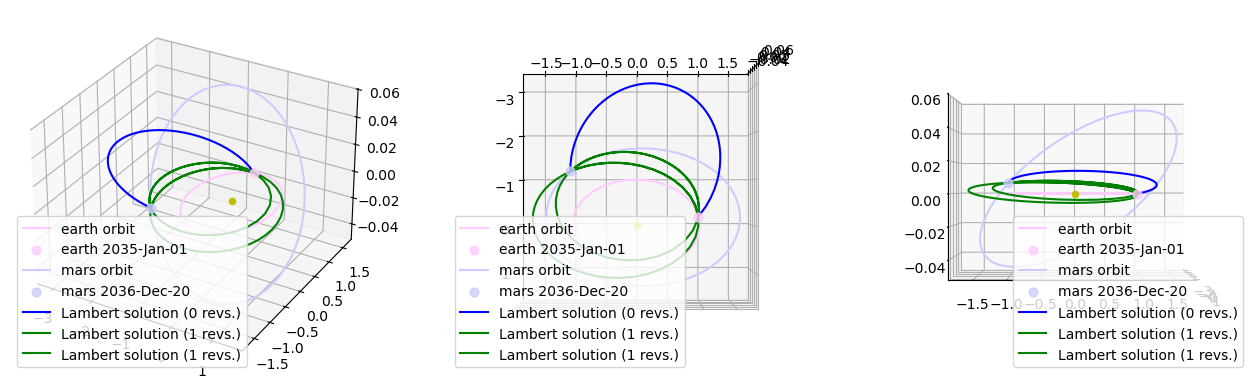

In [31]:
# We plot
mpl.rcParams['legend.fontsize'] = 10

# Create the figure and axis
fig = plt.figure(figsize = (16,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter([0], [0], [0], color=['y'])

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter([0], [0], [0], color=['y'])
ax2.view_init(90, 0)

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter([0], [0], [0], color=['y'])
ax3.view_init(0,0)

for ax in [ax1, ax2, ax3]:
    # Plot the planet orbits
    plot_planet(earth, t0=t1, color=(1, 0.8, 1), legend=True, units=AU, axes=ax)
    plot_planet(mars, t0=t2, color=(0.8, 0.8, 1), legend=True, units=AU, axes=ax)
    # Plot the Lambert solutions
    axis = plot_lambert(l, color='b', legend=True, units=AU, axes=ax)
    axis = plot_lambert(l, sol=1, color='g', legend=True, units=AU, axes=ax)
    axis = plot_lambert(l, sol=2, color='g', legend=True, units=AU, axes=ax)

=== Low-thrust results (Isp = 3000 s) ===
Constant thrust: m_final = 897.235 kg, TOF = 349.92 days
90 deg arc:      m_final = 988.631 kg, TOF = 2000.00 days
180 deg arc:     m_final = 978.732 kg, TOF = 2000.00 days

=== Impulsive comparison (Isp = 300 s) ===
Const thrust eq Δv = 3190.2 m/s -> impulsive m_final = 338.113 kg
90° arc    eq Δv = 336.4 m/s -> impulsive m_final = 891.950 kg
180° arc   eq Δv = 632.4 m/s -> impulsive m_final = 806.565 kg


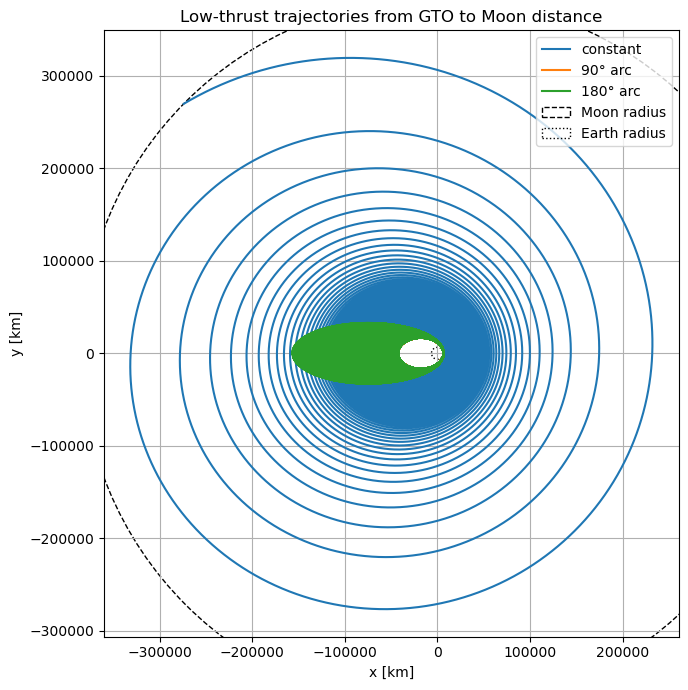

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ===========================================================
# 0. Constants and basic orbit setup
# ===========================================================
MU_EARTH = 398600.4418  # km^3/s^2
R_EARTH  = 6378.0       # km
g0       = 9.80665      # m/s^2

# GTO parameters: perigee 200 km, apogee 36000 km
rp = R_EARTH + 200.0
ra = R_EARTH + 36000.0
a0 = 0.5 * (rp + ra)
e0 = (ra - rp) / (ra + rp)

# Low-thrust engine
M0      = 1000.0   # kg
TMAX    = 0.1      # N
ISP_LT  = 3000.0   # s
R_TARGET = 384400.0  # km (Moon distance)

# Impulsive comparison
ISP_IMP = 300.0    # s


# ===========================================================
# 1. Initial GTO state at perigee (Cartesian)
# ===========================================================
def gto_perigee_state(mu=MU_EARTH):
    """
    Returns r0 (km), v0 (km/s) at perigee of the GTO.
    Perigee along +x, velocity along +y.
    """
    r0 = np.array([rp, 0.0])
    v_per = np.sqrt(mu * (2.0 / rp - 1.0 / a0))
    v0 = np.array([0.0, v_per])
    return r0, v0


# ===========================================================
# 2. True anomaly from r, v (osculating elements)
# ===========================================================
def true_anomaly_from_rv(r, v, mu=MU_EARTH):
    """
    Compute osculating true anomaly f from position r and velocity v.
    r, v are 2D (km, km/s) in the orbital plane.
    Returns f in radians, with perigee at f = 0.
    """
    R = np.linalg.norm(r)
    V = np.linalg.norm(v)

    r3 = np.array([r[0], r[1], 0.0])
    v3 = np.array([v[0], v[1], 0.0])

    h_vec = np.cross(r3, v3)
    h = np.linalg.norm(h_vec)

    e_vec = (1.0 / mu) * ((V**2 - mu / R) * r3 - np.dot(r, v) * v3)
    e = np.linalg.norm(e_vec)

    # handle near-circular numerical issues
    if e < 1e-10:
        # if nearly circular, use angle between r and x-axis instead
        cosf = r[0] / (R + 1e-15)
        cosf = np.clip(cosf, -1.0, 1.0)
        f = np.arccos(cosf)
        if r[1] < 0:
            f = -f
        return f

    cosf = np.dot(e_vec[:2], r) / (e * R + 1e-15)
    cosf = np.clip(cosf, -1.0, 1.0)
    f = np.arccos(cosf)

    # sign from radial component
    if np.dot(r, v) < 0:
        f = -f
    return f


# ===========================================================
# 3. Thrust on/off logic
# ===========================================================
def thrust_on_constant(t, y):
    """Always thrusting tangentially."""
    return 1.0


def make_thrust_on_arc(delta_f_deg):
    """
    Returns a thrust_on(t, y) function that is 1 if |true anomaly| <= delta_f/2,
    and 0 otherwise. delta_f_deg is total arc width around perigee.
    """
    delta_f = np.deg2rad(delta_f_deg)
    half_arc = 0.5 * delta_f

    def thrust_on_arc(t, y):
        x, y_pos, vx, vy, m = y
        r = np.array([x, y_pos])
        v = np.array([vx, vy])
        f = true_anomaly_from_rv(r, v)
        return 1.0 if abs(f) <= half_arc else 0.0

    return thrust_on_arc


thrust_on_90  = make_thrust_on_arc(90.0)   # ±45°
thrust_on_180 = make_thrust_on_arc(180.0)  # ±90°


# ===========================================================
# 4. Low-thrust dynamics
# ===========================================================
def low_thrust_dynamics(t, y, mu, T_max, Isp, thrust_on_fn):
    """
    State y = [x, y, vx, vy, m], units:
      x, y in km
      vx, vy in km/s
      m in kg
    mu in km^3/s^2
    Thrust T_max in N, Isp in s.
    """
    x, y_pos, vx, vy, m = y
    r_vec = np.array([x, y_pos])
    v_vec = np.array([vx, vy])

    r = np.linalg.norm(r_vec)
    v = np.linalg.norm(v_vec)

    # gravitational acceleration (km/s^2)
    a_grav = -mu * r_vec / r**3

    # thrust on/off
    u = thrust_on_fn(t, y)
    if u > 0.5 and v > 0.0 and m > 1e-6:
        v_hat = v_vec / v
        # T/m is m/s^2, convert to km/s^2 by /1000
        a_thrust = (T_max / m) / 1000.0 * v_hat
        mdot = -T_max / (Isp * g0)  # kg/s
    else:
        a_thrust = np.zeros(2)
        mdot = 0.0

    a_tot = a_grav + a_thrust

    return [vx, vy, a_tot[0], a_tot[1], mdot]


# ===========================================================
# 5. Event: reach lunar distance
# ===========================================================
def event_reach_moon(t, y):
    x, y_pos, vx, vy, m = y
    r = np.sqrt(x**2 + y_pos**2)
    return r - R_TARGET

event_reach_moon.terminal = True
event_reach_moon.direction = 1  # outward crossing


# ===========================================================
# 6. Simulation wrapper for one thrust case
# ===========================================================
def simulate_case(thrust_on_fn,
                  t_max_days=2000.0,
                  mu=MU_EARTH,
                  T_max=TMAX,
                  Isp=ISP_LT,
                  m0=M0):
    """
    Integrate until r = R_TARGET or t reaches t_max_days.
    Returns solution object, final mass, time of flight in days.
    """
    r0, v0 = gto_perigee_state(mu)
    y0 = [r0[0], r0[1], v0[0], v0[1], m0]

    t0 = 0.0
    t_max = t_max_days * 24.0 * 3600.0  # seconds

    sol = solve_ivp(
        fun=lambda t, y: low_thrust_dynamics(t, y, mu, T_max, Isp, thrust_on_fn),
        t_span=(t0, t_max),
        y0=y0,
        events=event_reach_moon,
        rtol=1e-8,
        atol=1e-8,
        max_step=500.0,  # seconds (can adjust)
    )

    if sol.status == 1 and len(sol.t_events[0]) > 0:
        # event triggered
        t_f = sol.t_events[0][0]
        y_f = sol.y_events[0][0]
    else:
        # did not reach target within t_max
        t_f = sol.t[-1]
        y_f = sol.y[:, -1]
        print("WARNING: did not reach R_TARGET within t_max_days")

    m_final = y_f[-1]
    tof_days = t_f / (24.0 * 3600.0)

    return sol, m_final, tof_days


# ===========================================================
# 7. Impulsive comparison utilities
# ===========================================================
def equivalent_delta_v(m0, mf, Isp):
    """Compute Δv from mass ratio and Isp (SI) in m/s."""
    return g0 * Isp * np.log(m0 / mf)


def impulsive_final_mass(m0, dv, Isp):
    """Final mass with impulsive burn of Δv (m/s), Isp (s)."""
    return m0 * np.exp(-dv / (g0 * Isp))


# ===========================================================
# 8. Run all three cases + compare
# ===========================================================
def run_all_cases():
    # Constant tangential thrust
    sol_const, m_const, tof_const = simulate_case(thrust_on_constant)

    # 90 deg tangential thrust arc (±45° around perigee)
    sol_90, m_90, tof_90 = simulate_case(thrust_on_90)

    # 180 deg tangential thrust arc (±90° around perigee)
    sol_180, m_180, tof_180 = simulate_case(thrust_on_180)

    print("=== Low-thrust results (Isp = 3000 s) ===")
    print(f"Constant thrust: m_final = {m_const:.3f} kg, TOF = {tof_const:.2f} days")
    print(f"90 deg arc:      m_final = {m_90:.3f} kg, TOF = {tof_90:.2f} days")
    print(f"180 deg arc:     m_final = {m_180:.3f} kg, TOF = {tof_180:.2f} days")

    # Equivalent Δv for each low-thrust case
    dv_const = equivalent_delta_v(M0, m_const, ISP_LT)
    dv_90    = equivalent_delta_v(M0, m_90,   ISP_LT)
    dv_180   = equivalent_delta_v(M0, m_180,  ISP_LT)

    # Impulsive final masses with Isp = 300 s
    m_imp_const = impulsive_final_mass(M0, dv_const, ISP_IMP)
    m_imp_90    = impulsive_final_mass(M0, dv_90,   ISP_IMP)
    m_imp_180   = impulsive_final_mass(M0, dv_180,  ISP_IMP)

    print("\n=== Impulsive comparison (Isp = 300 s) ===")
    print(f"Const thrust eq Δv = {dv_const:.1f} m/s -> impulsive m_final = {m_imp_const:.3f} kg")
    print(f"90° arc    eq Δv = {dv_90:.1f} m/s -> impulsive m_final = {m_imp_90:.3f} kg")
    print(f"180° arc   eq Δv = {dv_180:.1f} m/s -> impulsive m_final = {m_imp_180:.3f} kg")

    # Plot trajectories
    plt.figure(figsize=(7, 7))
    plt.plot(sol_const.y[0], sol_const.y[1], label="constant")
    plt.plot(sol_90.y[0],    sol_90.y[1],    label="90° arc")
    plt.plot(sol_180.y[0],   sol_180.y[1],   label="180° arc")

    # Add circles for initial GTO perigee and target radius
    circle_target = plt.Circle((0, 0), R_TARGET, fill=False, linestyle='--', label='Moon radius')
    plt.gca().add_artist(circle_target)
    circle_earth = plt.Circle((0, 0), R_EARTH, fill=False, linestyle=':', label='Earth radius')
    plt.gca().add_artist(circle_earth)

    plt.gca().set_aspect('equal', 'box')
    plt.xlabel("x [km]")
    plt.ylabel("y [km]")
    plt.title("Low-thrust trajectories from GTO to Moon distance")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ===========================================================
# 9. Main entry point
# ===========================================================
if __name__ == "__main__":
    run_all_cases()
